# Heart Failure Classification

# Import the needed libraries

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.tree
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,InputLayer
from tensorflow.keras import callbacks
from graphviz import Digraph
from copy import deepcopy

# Utilities

In [37]:
class ModelEvaluator:
    def __init__(self, model, model_name, color_theme="Blues"):
        self.model = model
        self.model_name = model_name
        self.color_theme = color_theme
        self.y_pred = None
        self.accuracy = None
        self.f1_score = None
        self.conf_matrix = None

    def evaluate(self, X_test, y_test):
        # Evaluate the model on the test set
        self.y_pred = self.model.predict(X_test)

        if isinstance(self.y_pred, list):
            self.y_pred = np.array(self.y_pred)

        self.y_pred = (self.y_pred > 0.5).astype(int)  # binary classification
        self.accuracy = accuracy_score(y_test, self.y_pred)
        self.f1_score = f1_score(y_test, self.y_pred)
        self.conf_matrix = confusion_matrix(y_test, self.y_pred)
        return self.accuracy, self.f1_score, self.conf_matrix

    def evaluate_bagging(self, X_test, y_test):
        y_m_model = []
        y_bagging = []

        for i in range(0, len(self.model)):
            y_m_model.append(self.model[i].predict(X_test))

        y_maj_vote = [sum(col) / len(col) for col in zip(*y_m_model)]
        for i in range(0, len(y_maj_vote)):
            if y_maj_vote[i] > 0.5:
                y_bagging.append(1)
            else:
                y_bagging.append(0)
        self.y_pred = y_bagging
        self.accuracy = accuracy_score(y_test, self.y_pred)
        self.f1_score = f1_score(y_test, self.y_pred)
        self.conf_matrix = confusion_matrix(y_test, self.y_pred)
        return self.accuracy, self.f1_score, self.conf_matrix

    def plot_confusion_matrix(
        self, font_size=14, title_font_size=16, annot_font_size=12
    ):
        # Plot the confusion matrix
        plt.figure(figsize=(5, 5))
        sns.heatmap(
            self.conf_matrix,
            annot=True,
            fmt="d",
            cmap=self.color_theme,
            xticklabels=["No heart disease", "Heart disease"],
            yticklabels=["No heart disease", "Heart disease"],
            annot_kws={"size": annot_font_size, "weight": "bold"},
            cbar_kws={"shrink": 0.8},
        )
        plt.xlabel("Predicted", fontsize=font_size, weight="bold")
        plt.ylabel("True", fontsize=font_size, weight="bold")
        plt.title(
            f"Confusion matrix for {self.model_name}",
            fontsize=title_font_size,
            weight="bold",
            pad=20,
        )
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.show()

    def print_metrics(self, y_test):
        # Print evaluation metrics
        print("Model", self.model_name)
        print("Accuracy", self.accuracy)
        print("F1-score:", self.f1_score)
        print("\nClassification report:")
        print(
            classification_report(
                y_test, self.y_pred, target_names=["No heart disease", "Heart disease"]
            )
        )

    def find_most_confusing_classes(self):
        confusion_matrix2 = self.conf_matrix.copy()
        np.fill_diagonal(
            confusion_matrix2, 0
        )  # because correct predictions are on the diagonal
        most_confusing = np.unravel_index(
            np.argmax(confusion_matrix2), confusion_matrix2.shape
        )
        print(
            f"Most confusing classes: True label {most_confusing[0]} --> predicted as {most_confusing[1]}"
        )

    def summarize(self, X_test, y_test):
        # Runs all evaluation steps and summarize the results
        self.evaluate(X_test, y_test)
        self.print_metrics(y_test)
        self.plot_confusion_matrix()
        self.find_most_confusing_classes()

    def summarize_bagging(self, X_test, y_test):
        # Runs all evaluation steps and summarize the results
        self.evaluate_bagging(X_test, y_test)
        self.print_metrics(y_test)
        self.plot_confusion_matrix()
        self.find_most_confusing_classes()

In [38]:
from rich.console import Console
from rich.table import Table


def display_rich_table(df, title="Table", width=200, rows=None):
    console = Console(width=width)
    table = Table(title=title, show_header=True, header_style="bold magenta")

    # add column headers
    for col in df.columns:
        table.add_column(col, justify="left", no_wrap=True)

    # determine the number of rows to display
    rows_to_display = df.shape[0] if rows is None else min(rows, df.shape[0])

    # add rows
    for row in df.head(rows_to_display).values:
        table.add_row(*map(str, row))

    console.print(table)

In [39]:
def plot_tuning_results(learners_num, losses, accuracies):
    plt.figure(figsize=(8, 4))
    sns.set_style("whitegrid")
    sns.set_palette("muted")

    # exponential loss plot
    plt.subplot(1, 2, 1)
    sns.lineplot(
        x=learners_num,
        y=losses,
        marker="o",
        markersize=8,
        linewidth=2.5,
        color="crimson",
        label="Exponential loss",
    )
    plt.xlabel("No. of weak learners", fontsize=5, fontweight="bold")
    plt.ylabel("Loss", fontsize=10, fontweight="bold")
    plt.title(
        "Exponential loss vs. No. of weak learners", fontsize=12, fontweight="bold"
    )
    plt.legend(fontsize=10)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    sns.lineplot(
        x=learners_num,
        y=accuracies,
        marker="o",
        markersize=8,
        linewidth=2.5,
        color="teal",
        label="Accuracy",
    )
    plt.xlabel("No. of weak learners", fontsize=10, fontweight="bold")
    plt.ylabel("Accuracy", fontsize=10, fontweight="bold")
    plt.title("Accuracy vs. No. of weak learners", fontsize=12, fontweight="bold")
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

# Data Preparation Step

In [40]:
class HeartDiseaseData:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None

    def load_data(self):
        # Load dataset from a CSV file
        self.df = pd.read_csv(self.data_path)
        display_rich_table(self.df, "Sample Data", width=250, rows=10)

    def split_features_target(self, target_column):
        # Split the dataset into features (X) and target (y)
        self.X = self.df.drop(columns=[target_column])
        self.y = self.df[target_column]

    def encode_categorical_columns(self, categorical_columns):
        # Perform one-hot encoding for categorical columns
        self.X = pd.get_dummies(self.X, columns=categorical_columns, dtype="uint8")
        display_rich_table(
            pd.DataFrame({"Columns": self.X.columns}), "Encoded Columns", width=250
        )

    def split_train_validation_test(
        self, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42
    ):
        # Split dataset into training, validation, and test sets while maintaining class distribution
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(
            self.X,
            self.y,
            test_size=(1 - train_size),
            stratify=self.y,
            random_state=random_state,
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            X_temp,
            y_temp,
            test_size=(test_size / (test_size + val_size)),
            stratify=y_temp,
            random_state=random_state,
        )

    def print_class_distribution(self):
        # Split dataset into training, validation, and test sets while maintaining class distribution
        class_dist = {
            "Dataset": ["Training", "Validation", "Test"],
            "Class Distribution": [
                self.y_train.value_counts(normalize=True).to_dict(),
                self.y_val.value_counts(normalize=True).to_dict(),
                self.y_test.value_counts(normalize=True).to_dict(),
            ],
        }
        display_rich_table(
            pd.DataFrame(class_dist), "Class Distribution", width=250, rows=10
        )

    def standardize_features(self, dataset):
        # Standardize numerical features using StandardScaler
        scaler = StandardScaler()
        self.df_standardized = pd.DataFrame(
            scaler.fit_transform(dataset), columns=dataset.columns
        )
        return self.df_standardized

    def preprocess_data(self, target_column, categorical_columns):
        # Run preprocessing steps
        self.load_data()
        self.split_features_target(target_column)
        self.encode_categorical_columns(categorical_columns)
        self.split_train_validation_test()
        self.print_class_distribution()

In [41]:
data_path = "heart.csv"
target_column = "HeartDisease"
categorical_columns = [
    "Sex",
    "ChestPainType",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]

# Initialize the data processor
data_processor = HeartDiseaseData(data_path)

# Preprocess the data
data_processor.preprocess_data(target_column, categorical_columns)

# Data
X_train = data_processor.X_train
X_val = data_processor.X_val
X_test = data_processor.X_test
y_train = data_processor.y_train
y_val = data_processor.y_val
y_test = data_processor.y_test
df_standardized = data_processor.standardize_features(X_train)
display_rich_table(
    pd.DataFrame(df_standardized), "Standardized Data Sample", width=250, rows=10
)

                                                                 Sample Data                                                                 
┏━━━━━┳━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Age ┃ Sex ┃ ChestPainType ┃ RestingBP ┃ Cholesterol ┃ FastingBS ┃ RestingECG ┃ MaxHR ┃ ExerciseAngina ┃ Oldpeak ┃ ST_Slope ┃ HeartDisease ┃
┡━━━━━╇━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 40  │ M   │ ATA           │ 140       │ 289         │ 0         │ Normal     │ 172   │ N              │ 0.0     │ Up       │ 0            │
│ 49  │ F   │ NAP           │ 160       │ 180         │ 0         │ Normal     │ 156   │ N              │ 1.0     │ Flat     │ 1            │
│ 37  │ M   │ ATA           │ 130       │ 283         │ 0         │ ST         │ 98    │ N              │ 0.0     │ Up       │ 0            │
│ 48  │ F   │ ASY           │ 138       │ 214         │ 0         │ Normal     │ 108   │ Y              │ 1.5     │ Flat     │ 1            │
│ 54  │ M   │ NAP           │ 150       │ 195         │ 0         │ Normal     │ 122   │ N              │ 0.0     │ Up       │ 0            │
│ 39  │ M   │ NAP           │ 120       │ 339         │ 0         │ Normal     │ 170   │ N              │ 0.0     │ Up       │ 0            │
│ 45  │ F   │ ATA           │ 130       │ 237         │ 0         │ Normal     │ 170   │ N              │ 0.0     │ Up       │ 0            │
│ 54  │ M   │ ATA           │ 110       │ 208         │ 0         │ Normal     │ 142   │ N              │ 0.0     │ Up       │ 0            │
│ 37  │ M   │ ASY           │ 140       │ 207         │ 0         │ Normal     │ 130   │ Y              │ 1.5     │ Flat     │ 1            │
│ 48  │ F   │ ATA           │ 120       │ 284         │ 0         │ Normal     │ 120   │ N              │ 0.0     │ Up       │ 0            │
└─────┴─────┴───────────────┴───────────┴─────────────┴───────────┴────────────┴───────┴────────────────┴─────────┴──────────┴──────────────┘

   Encoded Columns   
┏━━━━━━━━━━━━━━━━━━━┓
┃ Columns           ┃
┡━━━━━━━━━━━━━━━━━━━┩
│ Age               │
│ RestingBP         │
│ Cholesterol       │
│ FastingBS         │
│ MaxHR             │
│ Oldpeak           │
│ Sex_F             │
│ Sex_M             │
│ ChestPainType_ASY │
│ ChestPainType_ATA │
│ ChestPainType_NAP │
│ ChestPainType_TA  │
│ RestingECG_LVH    │
│ RestingECG_Normal │
│ RestingECG_ST     │
│ ExerciseAngina_N  │
│ ExerciseAngina_Y  │
│ ST_Slope_Down     │
│ ST_Slope_Flat     │
│ ST_Slope_Up       │
└───────────────────┘

                       Class Distribution                       
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Dataset    ┃ Class Distribution                              ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Training   │ {1: 0.5529595015576324, 0: 0.4470404984423676}  │
│ Validation │ {1: 0.5543478260869565, 0: 0.44565217391304346} │
│ Test       │ {1: 0.5543478260869565, 0: 0.44565217391304346} │
└────────────┴─────────────────────────────────────────────────┘

                                                                                                                 Standardized Data Sample                                                                                                                 
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Age       ┃ RestingBP   ┃ Cholester… ┃ FastingBS ┃ MaxHR      ┃ Oldpeak   ┃ Sex_F     ┃ Sex_M    ┃ ChestPai… ┃ ChestPai… ┃ ChestPai… ┃ ChestPainT… ┃ RestingE… ┃ RestingEC… ┃ RestingEC… ┃ ExerciseA… ┃ Exercise… ┃ ST_Slope… ┃ ST_Slope… ┃ ST_Slope_… ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ 0.856064… │ -0.6726184… │ -1.882351… │ 1.868023… │ -0.082371… │ -1.56327… │ -0.52085… │ 0.52085… │ -1.10867… │ -0.46713… │ -0.52085… │ 4.10284454… │ 1.994177… │ -1.248106… │ -0.484371… │ 0.8410985… │ -0.84109… │ -0.27454… │ 0.981479… │ -0.851942… │
│ 0.331342… │ 0.43546734… │ -1.882351… │ -0.53532… │ -0.629164… │ 1.037502… │ -0.52085… │ 0.52085… │ 0.901975… │ -0.46713… │ -0.52085… │ -0.2437333… │ -0.50145… │ 0.8012139… │ -0.484371… │ -1.188921… │ 1.188921… │ -0.27454… │ 0.981479… │ -0.851942… │
│ 0.331342… │ 0.98951021… │ 0.4896774… │ -0.53532… │ -1.722748… │ 1.966350… │ -0.52085… │ 0.52085… │ 0.901975… │ -0.46713… │ -0.52085… │ -0.2437333… │ -0.50145… │ 0.8012139… │ -0.484371… │ -1.188921… │ 1.188921… │ -0.27454… │ 0.981479… │ -0.851942… │
│ 1.905507… │ 1.54355308… │ -1.882351… │ -0.53532… │ -0.863503… │ 0.665963… │ -0.52085… │ 0.52085… │ -1.10867… │ -0.46713… │ 1.919930… │ -0.2437333… │ 1.994177… │ -1.248106… │ -0.484371… │ 0.8410985… │ -0.84109… │ -0.27454… │ 0.981479… │ -0.851942… │
│ 0.226398… │ 2.09759596… │ -1.882351… │ -0.53532… │ -0.511994… │ 1.501926… │ -0.52085… │ 0.52085… │ -1.10867… │ -0.46713… │ 1.919930… │ -0.2437333… │ 1.994177… │ -1.248106… │ -0.484371… │ -1.188921… │ 1.188921… │ -0.27454… │ 0.981479… │ -0.851942… │
│ 0.016509… │ -0.0077669… │ -0.189374… │ -0.53532… │ 0.1910244… │ -0.72730… │ -0.52085… │ 0.52085… │ -1.10867… │ 2.140702… │ -0.52085… │ -0.2437333… │ -0.50145… │ -1.248106… │ 2.0645326… │ 0.8410985… │ -0.84109… │ -0.27454… │ -1.01886… │ 1.1737877… │
│ 1.275841… │ 0.76789306… │ 0.7036252… │ -0.53532… │ 0.6206470… │ -0.82019… │ 1.919930… │ -1.9199… │ -1.10867… │ -0.46713… │ 1.919930… │ -0.2437333… │ 1.994177… │ -1.248106… │ -0.484371… │ 0.8410985… │ -0.84109… │ -0.27454… │ 0.981479… │ -0.851942… │
│ 0.961008… │ 0.21385019… │ -0.347509… │ -0.53532… │ -0.121428… │ -0.63442… │ -0.52085… │ 0.52085… │ -1.10867… │ 2.140702… │ -0.52085… │ -0.2437333… │ -0.50145… │ -1.248106… │ 2.0645326… │ 0.8410985… │ -0.84109… │ -0.27454… │ -1.01886… │ 1.1737877… │
│ 1.380785… │ 0.54627591… │ 0.6292086… │ 1.868023… │ -0.433881… │ 1.501926… │ -0.52085… │ 0.52085… │ -1.10867… │ -0.46713… │ -0.52085… │ 4.10284454… │ -0.50145… │ 0.8012139… │ -0.484371… │ 0.8410985… │ -0.84109… │ -0.27454… │ -1.01886… │ 1.1737877… │
│ 0.331342… │ -1.2266612… │ -0.049842… │ -0.53532… │ -1.410295… │ -0.82019… │ -0.52085… │ 0.52085… │ 0.901975… │ -0.46713… │ -0.52085… │ -0.2437333… │ 1.994177… │ -1.248106… │ -0.484371… │ 0.8410985… │ -0.84109… │ -0.27454… │ -1.01886… │ 1.1737877… │
└───────────┴─────────────┴────────────┴───────────┴────────────┴───────────┴───────────┴──────────┴───────────┴───────────┴───────────┴─────────────┴───────────┴────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴────────────┘

In [42]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (642, 20)
y_train shape: (642,)
X_val shape: (92, 20)
y_val shape: (92,)
X_test shape: (184, 20)
y_test shape: (184,)


# ML Classifiers

## Decision Tree

### Building the model

In [43]:
class DecisionTreeNode:
    def __init__(
        self,
        feature: int | None = None,
        threshold: float | None = None,
        predicted_class: int | None = None,
        depth: int | None = None,
        left: "DecisionTreeNode | None" = None,
        right: "DecisionTreeNode | None" = None,
        entropy: float | None = None,
        samples: int = 0,
        values: dict[int, int] | None = None,
        feat_idx: int | None = None,
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.predicted_class = predicted_class
        self.depth = depth
        self.entropy = entropy
        self.values = values
        self.samples = samples
        self.feat_idx = feat_idx

    def __str__(self):
        return (
            f"{self.feature} <= {self.threshold}\n"
            f"Entropy = {self.entropy}\n"
            f"Samples = {self.samples}\n"
            f"Values = {self.values}\n"
            f"Class = {self.predicted_class}\n"
            f"Node Depth = {self.depth}\n"
        )

In [44]:
class DecisionTreeUtils:
    @staticmethod
    def information_gain(y: np.ndarray, y1: np.ndarray, y2: np.ndarray) -> float:
        n, n1, n2 = len(y), len(y1), len(y2)
        y_entropy = DecisionTreeUtils.entropy(y)
        y_entropy_after_split_1 = DecisionTreeUtils.entropy(y1)
        y_entropy_after_split_2 = DecisionTreeUtils.entropy(y2)
        return (
            y_entropy
            - (n1 / n) * y_entropy_after_split_1
            - (n2 / n) * y_entropy_after_split_2
        )

    @staticmethod
    def entropy(y: np.ndarray) -> float:
        zeroes_number = np.count_nonzero(y == 0)
        prob_zero = zeroes_number / len(y)
        prob_one = 1 - prob_zero
        if prob_zero == 0 or prob_one == 0:
            return 0.0
        return -(prob_zero * np.log2(prob_zero) + prob_one * np.log2(prob_one))

In [45]:
class DecisionTreeBuilder:
    def __init__(self, max_depth: int = 4, min_samples_split: int = 1):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.utils = DecisionTreeUtils()

    def build_tree(
        self, X: np.ndarray, y: np.ndarray, curr_depth: int, columns: list
    ) -> DecisionTreeNode:
        if (
            curr_depth == self.max_depth
            or len(np.unique(y)) <= 1
            or (self.min_samples_split is not None and self.min_samples_split > len(y))
        ):
            return DecisionTreeNode(
                values=dict(Counter(y)),
                samples=len(y),
                entropy=round(self.utils.entropy(y), 3),
                predicted_class=Counter(y).most_common(1)[0][0],
                depth=curr_depth,
            )

        feature, threshold = self._best_split(X, y)
        tree_node = DecisionTreeNode(
            values=dict(Counter(y)),
            samples=len(y),
            entropy=round(self.utils.entropy(y), 3),
            feature=columns[feature],
            threshold=threshold,
            depth=curr_depth,
            feat_idx=feature,
        )

        threshold_mask = X[:, feature] <= threshold
        X_left_split, y_left_split = X[threshold_mask], y[threshold_mask]
        X_right_split, y_right_split = X[~threshold_mask], y[~threshold_mask]

        tree_node.left = self.build_tree(
            X_left_split, y_left_split, curr_depth + 1, columns
        )
        tree_node.right = self.build_tree(
            X_right_split, y_right_split, curr_depth + 1, columns
        )
        return tree_node

    def traverse_tree(
        self, x: np.ndarray, node: DecisionTreeNode
    ) -> int:  # returns a class (0/1)
        if node.predicted_class is not None:
            return node.predicted_class
        return (
            self.traverse_tree(x, node.left)
            if x[node.feat_idx] <= node.threshold
            else self.traverse_tree(x, node.right)
        )

    def _best_split(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[int, int]:  # feature and thresold are integers
        feat_num = X.shape[1]
        max_info_gain, feature, threshold = 0, None, None

        for n in range(feat_num):
            unique_values = np.unique(X[:, n])
            mid_points = (unique_values[:-1] + unique_values[1:]) / 2
            for split in mid_points:
                threshold_mask = X[:, n] <= split
                left_split, right_split = y[threshold_mask], y[~threshold_mask]

                info_gain = self.utils.information_gain(y, left_split, right_split)
                if info_gain > max_info_gain:
                    max_info_gain = info_gain
                    feature = n
                    threshold = split

        return feature, threshold

In [46]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int = 4, min_samples_split: int = 10):
        self.set_params(max_depth, min_samples_split)
        self.root = None

    def set_params(self, max_depth: int = 4, min_samples_split: int = 10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.builder = DecisionTreeBuilder(
            min_samples_split=min_samples_split, max_depth=max_depth
        )

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X_np, y_np = X.to_numpy(), y.to_numpy()
        self.root = self.builder.build_tree(X_np, y_np, 0, X.columns)

    def predict(self, X: pd.DataFrame) -> list[int]:
        X_np = X.to_numpy()
        y_pred = [self.builder.traverse_tree(row, self.root) for row in X_np]
        return y_pred

In [47]:
def plot_tree(model: DecisionTreeClassifier, dot: Digraph):
    def add_edges(node: DecisionTreeNode):
        if node:
            # Label each node with feature, threshold, class, and depth
            dot.node(str(id(node)), label=str(node))

            if node.left:
                dot.edge(str(id(node)), str(id(node.left)), label="T")  # Left child
                add_edges(node.left)
            if node.right:
                dot.edge(str(id(node)), str(id(node.right)), label="F")  # Right child
                add_edges(node.right)

    add_edges(model.root)
    display(dot)

### Tuning Hyperparameters Using the Validation Set

In [48]:
class HyperParameterTuner:
    def __init__(self, model: DecisionTreeClassifier, X_train: pd.DataFrame, y_train: pd.Series):
        self.model = deepcopy(model)
        self.X_train, self.y_train = X_train, y_train
        self.best_params_history = {"Max Depth": [], "Min Samples Split": [], "Accuracy": []}

    def fit(
        self, X_val: pd.DataFrame, y_val: pd.Series, param_grid: dict[str, list[int]],
    ) -> tuple[DecisionTreeClassifier, dict[str, list[int] | list[float]]]:
        best_model, best_accuracy = None, 0

        for max_depth, min_samples_split in [(d, s) for d in param_grid["max_depth"] for s in param_grid["min_samples_split"]]:
            temp_model = deepcopy(self.model)
            temp_model.set_params(max_depth=max_depth, min_samples_split=min_samples_split)
            temp_model.fit(self.X_train, self.y_train)

            accuracy = accuracy_score(y_val, temp_model.predict(X_val))

            if accuracy > best_accuracy:
                self._update_best_params_history(max_depth, min_samples_split, accuracy)
                best_accuracy, best_model = accuracy, temp_model

        display_rich_table(pd.DataFrame(self.best_params_history), "Hyperparameter Tuning Results")
        return best_model, self.best_params_history

    def _update_best_params_history(self, max_depth: int, min_samples_split: int, accuracy: float):
        self.best_params_history["Max Depth"].append(max_depth)
        self.best_params_history["Min Samples Split"].append(min_samples_split)
        self.best_params_history["Accuracy"].append(accuracy)


In [49]:
model = DecisionTreeClassifier()
fine_tuned_model = HyperParameterTuner(model, X_train, y_train)
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, None],
    "min_samples_split": [2, 3, 4, 20, 30, 40],
}
best_model, best_params = fine_tuned_model.fit(X_val, y_val, param_grid)

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8695652173913043 │
│ 5.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

### Evaluating the model

Model Decision Tree
Accuracy 0.8315217391304348
F1-score: 0.8426395939086294

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.79      0.85      0.82        82
   Heart disease       0.87      0.81      0.84       102

        accuracy                           0.83       184
       macro avg       0.83      0.83      0.83       184
    weighted avg       0.83      0.83      0.83       184



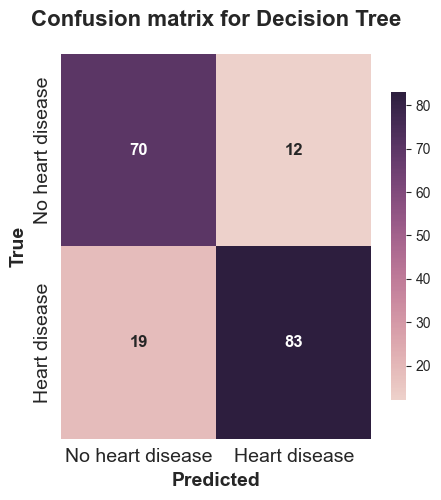

Most confusing classes: True label 1 --> predicted as 0


In [50]:
best_model.fit(X_train, y_train)
decision_tree_eval = ModelEvaluator(
    best_model, "Decision Tree", color_theme=sns.cubehelix_palette(as_cmap=True)
)
decision_tree_eval.summarize(X_test, y_test)

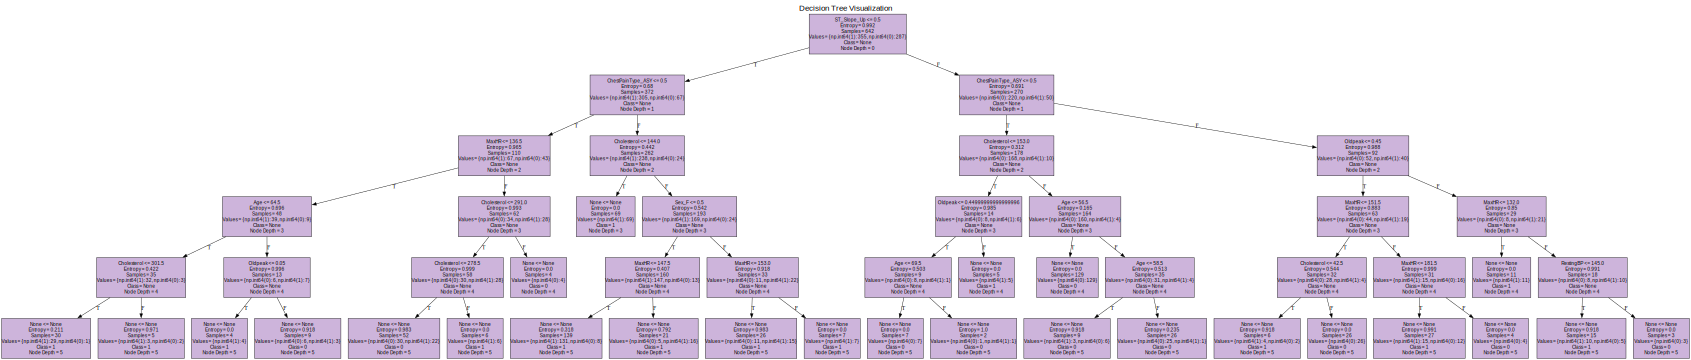

In [51]:
dot = Digraph()
dot.attr(size="25,5")
dot.attr(
    label="Decision Tree Visualization", labelloc="t", fontsize="20", fontname="Arial"
)
dot.attr(
    "node",
    shape="box",
    width="0",
    height="0",
    margin="0.1",
    style="filled",
    fillcolor="#cdb4db",
    fontname="Arial",
    fontsize="12",
)
plot_tree(best_model, dot)

## Bagging

In [52]:
class Bagging_Classifier:
    def __init__(self):
        self.best_params_history = {"No_Models": [], "Accuracy": []}

    def train_single_model(self, m):
        X_resampled, y_resampled = resample(
            X_train, y_train, replace=True, random_state=m
        )
        decision_tree_model = DecisionTreeClassifier()
        decision_tree_model.fit(X_resampled, y_resampled)
        return decision_tree_model
    
    def train_single_model_with_tunning_decision_tree(self, m):
        X_resampled, y_resampled = resample(
            X_train, y_train, replace=True, random_state=m
        )
        model = DecisionTreeClassifier()
        fine_tuned_model = HyperParameterTuner(model, X_resampled, y_resampled)
        param_grid = {
            "max_depth": [2, 3, 4, 5, 6, None],
            "min_samples_split": [2],
        }
        best_model, best_params = fine_tuned_model.fit(X_val, y_val, param_grid)
        return best_model

    def validate_bagging_model(self, m_models):
        y_m_model = []
        y_bagging = []

        for i in range(0, len(m_models)):
            y_m_model.append(m_models[i].predict(X_val))

        y_maj_vote = [sum(col) / len(col) for col in zip(*y_m_model)]
        for i in range(0, len(y_maj_vote)):
            if y_maj_vote[i] > 0.5:
                y_bagging.append(1)
            else:
                y_bagging.append(0)

        accuracy = accuracy_score(y_val, y_bagging)
        return accuracy
    
    def update_best_params_history(self, m: int, accuracy: float):
        self.best_params_history["No_Models"].append(m)
        self.best_params_history["Accuracy"].append(accuracy)

* Bagging without tunning the decision tree (just validate over the number of models)

In [53]:
best_m = 1
best_accuracy = 0
best_models = []
best_params_history = {"No_Models": [], "Accuracy": []}
Bagging_classifier = Bagging_Classifier()
m_models = []
for m in range(1, 31):
    m_models.append(Bagging_classifier.train_single_model(m))
    accuracy = Bagging_classifier.validate_bagging_model(m_models)
    if accuracy > best_accuracy:
        Bagging_classifier.update_best_params_history(m, accuracy)
        best_accuracy = accuracy
        best_m = m
        best_models = m_models

display_rich_table(pd.DataFrame(Bagging_classifier.best_params_history), "Hyperparameter Tuning Results")

print(f"Best_M_According_to_Validation: {best_m}")
print(f"Best_Accuracy: {best_accuracy}\n")

  Hyperparameter Tuning Results   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ No_Models ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 1.0       │ 0.782608695652174  │
│ 2.0       │ 0.8478260869565217 │
│ 6.0       │ 0.8913043478260869 │
└───────────┴────────────────────┘

Best_M_According_to_Validation: 6
Best_Accuracy: 0.8913043478260869



Model Bagging
Accuracy 0.8695652173913043
F1-score: 0.8811881188118812

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.85      0.87      0.86        82
   Heart disease       0.89      0.87      0.88       102

        accuracy                           0.87       184
       macro avg       0.87      0.87      0.87       184
    weighted avg       0.87      0.87      0.87       184



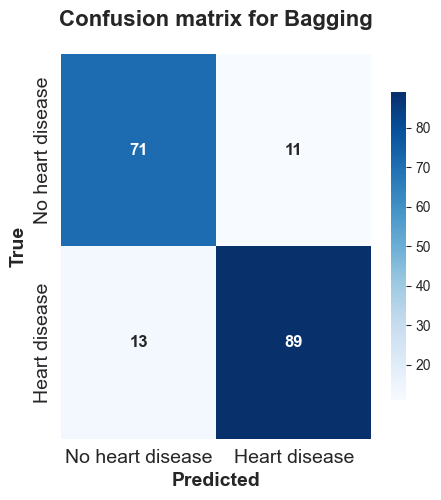

Most confusing classes: True label 1 --> predicted as 0


In [54]:
# Evaluation
bagging_eval = ModelEvaluator(best_models, "Bagging")
bagging_eval.summarize_bagging(X_test, y_test)

* Bagging with tunning the decision tree (validate over the number of models and max depth of tree)

In [55]:
best_m = 1
best_accuracy = 0
best_models = []
Bagging_classifier = Bagging_Classifier()
m_models = []
for m in range(1, 31):
    m_models.append(Bagging_classifier.train_single_model_with_tunning_decision_tree(m))
    accuracy = Bagging_classifier.validate_bagging_model(m_models)
    if accuracy > best_accuracy:
        Bagging_classifier.update_best_params_history(m, accuracy)
        best_accuracy = accuracy
        best_m = m
        best_models = m_models

display_rich_table(pd.DataFrame(Bagging_classifier.best_params_history), "Hyperparameter Tuning Results")

print(f"Best_M_According_to_Validation: {best_m}")
print(f"Best_Accuracy: {best_accuracy}\n")

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8586956521739131 │
│ 3.0       │ 2.0               │ 0.8695652173913043 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8586956521739131 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8913043478260869 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8804347826086957 │
│ 5.0       │ 2.0               │ 0.9021739130434783 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8586956521739131 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8586956521739131 │
│ 3.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8586956521739131 │
│ 3.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8695652173913043 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 5.0       │ 2.0               │ 0.8586956521739131 │
│ 6.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8586956521739131 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8586956521739131 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8804347826086957 │
│ 4.0       │ 2.0               │ 0.9130434782608695 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8369565217391305 │
│ 5.0       │ 2.0               │ 0.8478260869565217 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8913043478260869 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8695652173913043 │
│ 6.0       │ 2.0               │ 0.8804347826086957 │
│ nan       │ 2.0               │ 0.8913043478260869 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 4.0       │ 2.0               │ 0.8586956521739131 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8804347826086957 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8695652173913043 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
└───────────┴───────────────────┴────────────────────┘

            Hyperparameter Tuning Results             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Max Depth ┃ Min Samples Split ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 2.0       │ 2.0               │ 0.8478260869565217 │
│ 3.0       │ 2.0               │ 0.8913043478260869 │
└───────────┴───────────────────┴────────────────────┘

  Hyperparameter Tuning Results   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ No_Models ┃ Accuracy           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 1.0       │ 0.8478260869565217 │
│ 4.0       │ 0.8586956521739131 │
│ 5.0       │ 0.8913043478260869 │
│ 7.0       │ 0.9021739130434783 │
│ 14.0      │ 0.9130434782608695 │
└───────────┴────────────────────┘

Best_M_According_to_Validation: 14
Best_Accuracy: 0.9130434782608695



Model Bagging
Accuracy 0.8097826086956522
F1-score: 0.8292682926829268

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.79      0.78      0.79        82
   Heart disease       0.83      0.83      0.83       102

        accuracy                           0.81       184
       macro avg       0.81      0.81      0.81       184
    weighted avg       0.81      0.81      0.81       184



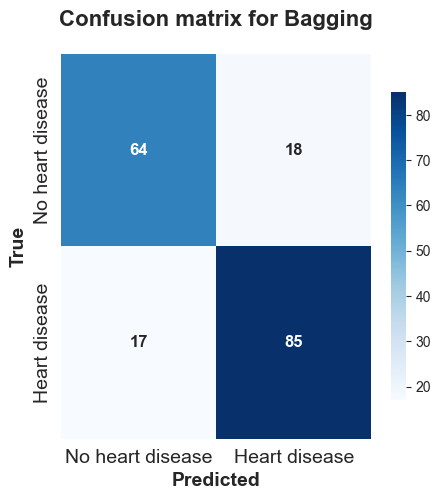

Most confusing classes: True label 0 --> predicted as 1


In [56]:
# Evaluation
bagging_eval = ModelEvaluator(best_models, "Bagging")
bagging_eval.summarize_bagging(X_test, y_test)

## AdaBoost

### Decision Stump

In [57]:
class DecisionStump:
    def __init__(self):
        self.feature = None
        self.threshold = None
        self.below_threshold_class = None
        self.above_threshold_class = None

    def fit(self, X, y, sample_weights):
        # convert input to np arrays for efficiency
        X_np, y_np = np.asarray(X), np.asarray(y)
        features = X_np.shape[1]
        best_err, best_feature, best_threshold = float("inf"), None, None

        for f in range(features):
            # sort feature values and corresponding labels and weights to efficiently compute thresholds
            sorted_indices = np.argsort(X_np[:, f])
            X_sorted, y_sorted, weights_sorted = (
                X_np[sorted_indices, f],
                y_np[sorted_indices],
                sample_weights[sorted_indices],
            )

            # compute cumulative sums to determine error at each split point
            cum_class_1 = np.cumsum(weights_sorted * (y_sorted == 1))
            cum_class_0 = np.cumsum(weights_sorted * (y_sorted == -1))
            total_1, total_0 = cum_class_1[-1], cum_class_0[-1]

            # find the best threshold minimizing weighted error
            err_below = cum_class_1 + (total_0 - cum_class_0)
            err_above = cum_class_0 + (total_1 - cum_class_1)

            min_err_index = np.argmin(err_below + err_above)
            err = (err_below + err_above)[min_err_index]

            # if this split is better update parameters
            if err < best_err:
                best_err = err
                best_feature = f
                best_threshold = X_sorted[min_err_index]
                self.below_threshold_class = (
                    -1 if cum_class_0[min_err_index] > cum_class_1[min_err_index] else 1
                )
                self.above_threshold_class = -self.below_threshold_class

        self.feature, self.threshold = best_feature, best_threshold

    def predict(self, X):
        feature_column = np.asarray(X)[:, self.feature]
        # assign class labels based on the threshold comparison
        return np.where(
            feature_column <= self.threshold,
            self.below_threshold_class,
            self.above_threshold_class,
        )

### Building AdaBoost

In [58]:
class AdaBoost:
    def __init__(self, num_weak_learners=50):
        self.num_weak_learners = num_weak_learners
        self.weak_learners = []

    def fit(self, X, y):
        samples_num = X.shape[0]
        sample_weights = np.full(
            samples_num, 1 / samples_num
        )  # Initailly all samples are equally weighted where w = 1/samples_num
        training_logs = []

        for i in range(self.num_weak_learners):
            stump = DecisionStump()
            stump.fit(X, y, sample_weights)
            predictions = stump.predict(X)

            # computing the weighted error
            err = np.dot(sample_weights, predictions != y) / np.sum(sample_weights)

            # compute alpha using error
            stump.alpha = 0.5 * np.log((1 - err) / (err + 1e-10))

            # updating the weights of samples
            sample_weights *= np.exp(-stump.alpha * y * predictions)
            # Normalization
            sample_weights /= np.sum(sample_weights)

            self.weak_learners.append(stump)
            training_logs.append(
                [i + 1, stump.feature, stump.threshold, stump.alpha, err]
            )

        df_logs = pd.DataFrame(
            training_logs,
            columns=["Iteration", "Feature", "Threshold", "Alpha", "Error"],
        )
        display_rich_table(df_logs, "AdaBoost training progress")

    def predict(self, X):
        # combine weak learners' weighted predictions
        return np.sign(
            sum(stump.alpha * stump.predict(X) for stump in self.weak_learners)
        )

### Tuning AdaBoost hyperameters (Weak learners number)

In [59]:
def tune_hyperparameters(X_train, y_train, X_val, y_val, learners_num):
    # train adaboost once with the maximum number of weak learners
    model = AdaBoost(num_weak_learners=max(learners_num))
    model.fit(X_train, y_train)

    best_num, best_accuracy, best_loss = None, 0, float("inf")
    losses, accuracies, tuning_logs = [], [], []

    for t in learners_num:
        # use only the first t weak learners instead of retraining
        sub_weak_learners = model.weak_learners[:t]
        final_predictions = sum(
            stump.alpha * stump.predict(X_val) for stump in sub_weak_learners
        )
        y_val_pred = np.sign(final_predictions)

        # Compute accuracy and exponential loss
        accuracy = np.mean(y_val_pred == y_val)
        loss = np.mean(np.exp(-y_val * final_predictions))

        tuning_logs.append([t, accuracy, loss])
        losses.append(loss)
        accuracies.append(accuracy)

        # select the best model based on minimum loss then accuracy
        if loss < best_loss or (loss == best_loss and accuracy > best_accuracy):
            best_loss, best_accuracy, best_num = loss, accuracy, t

    df_tuning_logs = pd.DataFrame(
        tuning_logs, columns=["Weak Learners", "Accuracy", "Exponential Loss"]
    )
    display_rich_table(df_tuning_logs, "Hyperparameter tuning results")
    print(
        f"\nBest number of weak learners: {best_num} | Accuracy: {best_accuracy:.4f} | Exponential Loss: {best_loss:.4f}"
    )
    return best_num, learners_num, losses, accuracies

In [60]:
# find the best number of weak learners
best_num, learners_num, losses, accuracies = tune_hyperparameters(
    X_train,
    np.where(np.asarray(y_train) == 0, -1, np.asarray(y_train)),
    X_val,
    np.where(np.asarray(y_val) == 0, -1, np.asarray(y_val)),
    learners_num=[5, 10, 20, 30, 40, 50],
)

                            AdaBoost training progress                             
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Iteration ┃ Feature ┃ Threshold ┃ Alpha                   ┃ Error               ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 1.0       │ 0.0     │ 29.0      │ 0.10946945990385125     │ 0.4454828660436137  │
│ 2.0       │ 0.0     │ 30.0      │ 0.003496517756980706    │ 0.4982517481958258  │
│ 3.0       │ 0.0     │ 32.0      │ -0.0013800610578006312  │ 0.5006900300408995  │
│ 4.0       │ 1.0     │ 94.0      │ -0.0007286138960870954  │ 0.5003643068336124  │
│ 5.0       │ 18.0    │ 0.0       │ 0.6085060686166911      │ 0.22846268622316257 │
│ 6.0       │ 19.0    │ 0.0       │ 0.22092799916040728     │ 0.39129881091481467 │
│ 7.0       │ 19.0    │ 0.0       │ -2.2777979507752358e-10 │ 0.5000000000638899  │
│ 8.0       │ 19.0    │ 0.0       │ -2.0000023863267923e-10 │ 0.5000000000500001  │
│ 9.0       │ 18.0    │ 0.0       │ 0.1730365557249778      │ 0.41433500405321316 │
│ 10.0      │ 18.0    │ 0.0       │ -2.2067547793976124e-10 │ 0.5000000000603377  │
│ 11.0      │ 19.0    │ 0.0       │ 0.14001243206469177     │ 0.4304476802417803  │
│ 12.0      │ 5.0     │ -0.5      │ 0.07228281425830058     │ 0.4639214054846738  │
│ 13.0      │ 18.0    │ 0.0       │ 0.11451976156106307     │ 0.44298912979057825 │
│ 14.0      │ 18.0    │ 0.0       │ -2.1286972189484254e-10 │ 0.5000000000564349  │
│ 15.0      │ 19.0    │ 0.0       │ 0.10843375608538154     │ 0.445994619093067   │
│ 16.0      │ 5.0     │ -2.6      │ -0.0051223541981458886  │ 0.5025611546490717  │
│ 17.0      │ 19.0    │ 0.0       │ -0.000850173391898778   │ 0.5004250865435751  │
│ 18.0      │ 18.0    │ 0.0       │ -0.09050843724843123    │ 0.5451310513208443  │
│ 19.0      │ 5.0     │ -2.6      │ -0.0008949190974982716  │ 0.5004474593793401  │
│ 20.0      │ 19.0    │ 0.0       │ 0.07665936050890013     │ 0.46174522708294796 │
│ 21.0      │ 5.0     │ 0.0       │ 0.06486067777151922     │ 0.46761506180935436 │
│ 22.0      │ 18.0    │ 0.0       │ -0.08788129524509036    │ 0.5438278762811398  │
│ 23.0      │ 17.0    │ 0.0       │ 0.07420415455588691     │ 0.46296587086823937 │
│ 24.0      │ 18.0    │ 0.0       │ -0.012803393190915191   │ 0.5064013467656558  │
│ 25.0      │ 18.0    │ 0.0       │ -1.9873591665173196e-10 │ 0.500000000049368   │
│ 26.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 27.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 28.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 29.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 30.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 31.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 32.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 33.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 34.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 35.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 36.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 37.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 38.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 39.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 40.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 41.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 42.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 43.0      │ 18.0    │ 0.0       │ 0.0                     │ 0.49999999995       │
│ 44.0      │ 18.0    │ 0.0       │ 0.0             

               Hyperparameter tuning results               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Weak Learners ┃ Accuracy           ┃ Exponential Loss   ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 5.0           │ 0.8260869565217391 │ 0.7579222869210775 │
│ 10.0          │ 0.8260869565217391 │ 0.7290265605590384 │
│ 20.0          │ 0.8478260869565217 │ 0.7076984677962379 │
│ 30.0          │ 0.8478260869565217 │ 0.7156928462849956 │
│ 40.0          │ 0.8478260869565217 │ 0.7156928462849956 │
│ 50.0          │ 0.8478260869565217 │ 0.7156928462849956 │
└───────────────┴────────────────────┴────────────────────┘


Best number of weak learners: 20 | Accuracy: 0.8478 | Exponential Loss: 0.7077


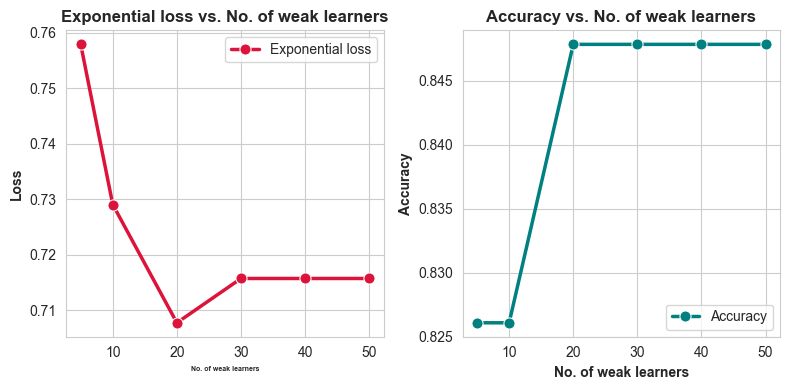

In [61]:
plot_tuning_results(learners_num, losses, accuracies)

In [62]:
# train adaboost model
adaboost_model = AdaBoost(num_weak_learners=best_num)
adaboost_model.fit(X_train, np.where(np.asarray(y_train) == 0, -1, np.asarray(y_train)))

                            AdaBoost training progress                             
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Iteration ┃ Feature ┃ Threshold ┃ Alpha                   ┃ Error               ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 1.0       │ 0.0     │ 29.0      │ 0.10946945990385125     │ 0.4454828660436137  │
│ 2.0       │ 0.0     │ 30.0      │ 0.003496517756980706    │ 0.4982517481958258  │
│ 3.0       │ 0.0     │ 32.0      │ -0.0013800610578006312  │ 0.5006900300408995  │
│ 4.0       │ 1.0     │ 94.0      │ -0.0007286138960870954  │ 0.5003643068336124  │
│ 5.0       │ 18.0    │ 0.0       │ 0.6085060686166911      │ 0.22846268622316257 │
│ 6.0       │ 19.0    │ 0.0       │ 0.22092799916040728     │ 0.39129881091481467 │
│ 7.0       │ 19.0    │ 0.0       │ -2.2777979507752358e-10 │ 0.5000000000638899  │
│ 8.0       │ 19.0    │ 0.0       │ -2.0000023863267923e-10 │ 0.5000000000500001  │
│ 9.0       │ 18.0    │ 0.0       │ 0.1730365557249778      │ 0.41433500405321316 │
│ 10.0      │ 18.0    │ 0.0       │ -2.2067547793976124e-10 │ 0.5000000000603377  │
│ 11.0      │ 19.0    │ 0.0       │ 0.14001243206469177     │ 0.4304476802417803  │
│ 12.0      │ 5.0     │ -0.5      │ 0.07228281425830058     │ 0.4639214054846738  │
│ 13.0      │ 18.0    │ 0.0       │ 0.11451976156106307     │ 0.44298912979057825 │
│ 14.0      │ 18.0    │ 0.0       │ -2.1286972189484254e-10 │ 0.5000000000564349  │
│ 15.0      │ 19.0    │ 0.0       │ 0.10843375608538154     │ 0.445994619093067   │
│ 16.0      │ 5.0     │ -2.6      │ -0.0051223541981458886  │ 0.5025611546490717  │
│ 17.0      │ 19.0    │ 0.0       │ -0.000850173391898778   │ 0.5004250865435751  │
│ 18.0      │ 18.0    │ 0.0       │ -0.09050843724843123    │ 0.5451310513208443  │
│ 19.0      │ 5.0     │ -2.6      │ -0.0008949190974982716  │ 0.5004474593793401  │
│ 20.0      │ 19.0    │ 0.0       │ 0.07665936050890013     │ 0.46174522708294796 │
└───────────┴─────────┴───────────┴─────────────────────────┴─────────────────────┘

Model AdaBoost
Accuracy 0.782608695652174
F1-score: 0.8

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.74      0.78      0.76        82
   Heart disease       0.82      0.78      0.80       102

        accuracy                           0.78       184
       macro avg       0.78      0.78      0.78       184
    weighted avg       0.78      0.78      0.78       184



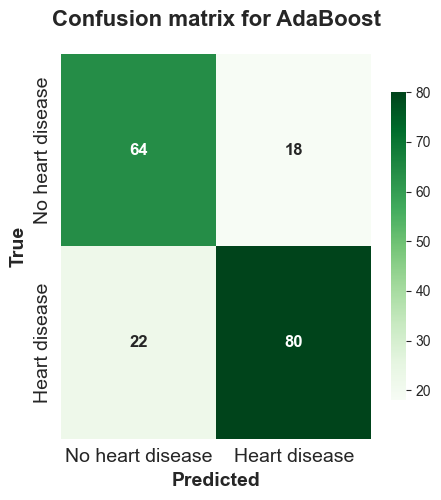

Most confusing classes: True label 1 --> predicted as 0


In [63]:
# evaluate the model
evaluator = ModelEvaluator(adaboost_model, model_name="AdaBoost", color_theme="Greens")
evaluator.summarize(X_test, y_test)

## Logistic Regression

## KNN

In [64]:
class KNN_Classifier:
    def train_knn_model(self, n_neighbors):
        knn = KNeighborsClassifier(n_neighbors)
        knn.fit(data_processor.standardize_features(X_train), y_train)
        return knn

    def validate_knn_model(self, knn):
        y_pred = knn.predict(data_processor.standardize_features(X_val))
        accuracy = accuracy_score(y_val, y_pred)
        return accuracy

Best_K_According_to_Validation: 19
Best_Accuracy: 0.9456521739130435

Model KNN
Accuracy 0.8858695652173914
F1-score: 0.896551724137931

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.87      0.88      0.87        82
   Heart disease       0.90      0.89      0.90       102

        accuracy                           0.89       184
       macro avg       0.88      0.89      0.88       184
    weighted avg       0.89      0.89      0.89       184



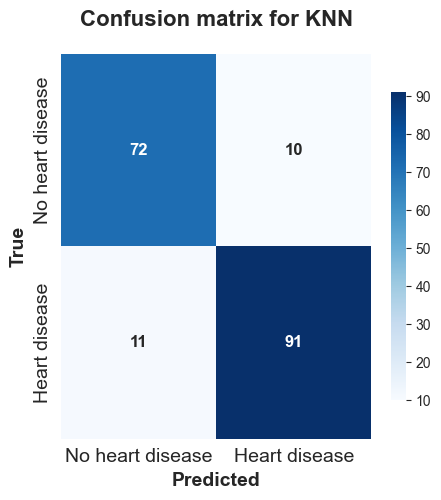

Most confusing classes: True label 1 --> predicted as 0


In [65]:
best_k = 1
best_accuracy = 0
knn_classifier = KNN_Classifier()
for k in range(1, 31):
    knn = knn_classifier.train_knn_model(k)
    accuracy = knn_classifier.validate_knn_model(knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Best_K_According_to_Validation: {best_k}")
print(f"Best_Accuracy: {best_accuracy}\n")

best_knn = knn_classifier.train_knn_model(best_k)
knn_eval = ModelEvaluator(best_knn, "KNN")
knn_eval.summarize(data_processor.standardize_features(X_test), y_test)

## FNN

### Training callbacks 

In [66]:
class TrainingCallbacks:
    def __init__(
        self,
        early_stopping_patience=20,
        reduce_lr_patience=3,
        reduce_lr_factor=0.2,
        min_lr=1e-5,
    ):
        self.early_stopping_patience = early_stopping_patience
        self.reduce_lr_patience = reduce_lr_patience
        self.reduce_lr_factor = reduce_lr_factor
        self.min_lr = min_lr

    def get_callbacks(self):
        # Early stopping callbacks
        es = callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=self.early_stopping_patience,  # Stopping after certain number of epochs with no improvement
            verbose=1,
            mode="max",  # because we want to maximize the validation accuracy
            restore_best_weights=True,
        )

        # Learning rate reduction callbacks
        rp = callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=self.reduce_lr_factor,
            patience=self.reduce_lr_patience,  # wait for certain number of epochs before lr reduction
            verbose=1,
            mode="max",
            min_lr=self.min_lr,
        )

        return [es, rp]

### Build the model

In [67]:
class FeedforwardNeuralNetwork:
    def __init__(self, input_size, hidden_neurons=16, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        # Input layer
        model.add(InputLayer(shape=(self.input_size,)))
        # Hidden layer
        model.add(Dense(self.hidden_neurons, activation="relu"))
        # Output layer
        model.add(Dense(1, activation="sigmoid"))
        model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
        )
        return model

    def train(
        self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, callbacks=None
    ):
        history = self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1,
        )
        return history

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print("Test loss:", loss)
        print("Test accuracy:", accuracy)
        return loss, accuracy

    def predict(self, X):
        return self.model.predict(X)

In [68]:
# Initializing FNN
input_size = X_train.shape[1]
fnn_model = FeedforwardNeuralNetwork(
    input_size=input_size, hidden_neurons=16, learning_rate=0.001
)

# Setting up training callbacks
training_callbacks = TrainingCallbacks(
    early_stopping_patience=20, reduce_lr_patience=20, reduce_lr_factor=0.2, min_lr=1e-5
)
callbacks_list = training_callbacks.get_callbacks()

# Train the model
history = fnn_model.train(
    X_train, y_train, X_val, y_val, epochs=50, batch_size=32, callbacks=callbacks_list
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4323 - loss: 47.4982 - val_accuracy: 0.4457 - val_loss: 24.5998 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4535 - loss: 18.3730 - val_accuracy: 0.5326 - val_loss: 4.5134 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5659 - loss: 4.5949 - val_accuracy: 0.5326 - val_loss: 3.9650 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5993 - loss: 3.3734 - val_accuracy: 0.5870 - val_loss: 3.4727 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6083 - loss: 2.9274 - val_accuracy: 0.5761 - val_loss: 3.1710 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6548 - loss: 2.8089 - val_accuracy: 0.6196 - val_loss: 2.8576 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5794 - loss: 2.7724 - val_accura

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Model FNN
Accuracy 0.8532608695652174
F1-score: 0.8682926829268293

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.84      0.83      0.83        82
   Heart disease       0.86      0.87      0.87       102

        accuracy                           0.85       184
       macro avg       0.85      0.85      0.85       184
    weighted avg       0.85      0.85      0.85       184



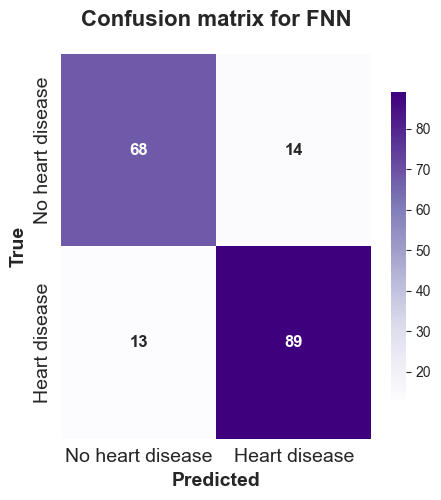

Most confusing classes: True label 0 --> predicted as 1


In [69]:
# Evaluate the model
fnn_evaluator = ModelEvaluator(fnn_model, "FNN", color_theme="Purples")
fnn_evaluator.summarize(X_test, y_test)

In [70]:
# Make predictions on the test set
predictions = fnn_model.predict(X_test)

results = pd.DataFrame(
    {
        "Actual": y_test,
        "Predicted": predictions.flatten(),
        "Probability": predictions.flatten(),
    }
)

# Printing the results of predictions
print("Predictions vs Actual Labels:")
print("-" * 30)
print(results.head(10))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Predictions vs Actual Labels:
------------------------------
     Actual  Predicted  Probability
652       1   0.031098     0.031098
117       1   0.993334     0.993334
800       0   0.028844     0.028844
274       0   0.000077     0.000077
669       0   0.040869     0.040869
488       0   0.354328     0.354328
12        0   0.009093     0.009093
605       0   0.611794     0.611794
212       0   0.606625     0.606625
709       1   0.462336     0.462336


# Analysis and Comparison